<a href="https://colab.research.google.com/github/rsekhar-vai/nlptc_multimodels/blob/master/Text_Classification_Trying_different_Model_Architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup the Environment

In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
!rm -r nlptc_multimodels
!git clone https://github.com/rsekhar-vai/nlptc_multimodels.git

Cloning into 'nlptc_multimodels'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 108 (delta 48), reused 84 (delta 29), pack-reused 0
Receiving objects: 100% (108/108), 41.80 MiB | 10.62 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [65]:
!ls nlptc_multimodels -R

nlptc_multimodels:
 data	      'Model Repo'   model_storage   README.md	 utilclasses.py
 __init__.py   models.py     __pycache__     run.py	 utilfunctions.py

nlptc_multimodels/data:
bbcheadlines_text.csv  init	 sample_submission.csv	train.csv
humor_text.csv	       news.csv  test.csv		val.csv

'nlptc_multimodels/Model Repo':
CharCNN_Simple.py  ConvRec_BiLSTM.py  __init__.py  VDCNN.py

nlptc_multimodels/model_storage:
Clf

nlptc_multimodels/model_storage/Clf:
model.pth

nlptc_multimodels/__pycache__:
__init__.cpython-36.pyc  utilclasses.cpython-36.pyc
models.cpython-36.pyc	 utilfunctions.cpython-36.pyc


In [66]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sys
import spacy
import torchtext
from torchtext import data
from torchtext.data import Field, BucketIterator
from torchtext import vocab


print('Python version:',sys.version)
print('Pandas version:',pd.__version__)
print('Pytorch version:', torch.__version__)
print('Torch Text version:', torchtext.__version__)
print('Spacy version:', spacy.__version__)


Python version: 3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
Pandas version: 1.0.3
Pytorch version: 1.5.0+cu101
Torch Text version: 0.3.1
Spacy version: 2.2.4


In [0]:
import sys
sys.path.append("nlptc_multimodels")

In [0]:
from nlptc_multimodels.utilfunctions import *
from nlptc_multimodels.utilclasses import *
from nlptc_multimodels.models import *


In [69]:
  args = Namespace(
      #text_csv=None, # updated subsequently
      train_csv="nlptc_multimodels/data/train.csv",
      val_csv="nlptc_multimodels/data/val.csv",
      test_csv="nlptc_multimodels/data/test.csv",
      model_state_file="model.pth",
      save_dir="model_storage/Clf",
      glove_filepath='D:\\Projects\\Text Analytics\\Glove\\glove.6B.100d.txt',
      hidden_dim=100,
      num_channels=100,
      seed=1337,
      learning_rate=0.001,
      dropout_p=0.1,
      batch_size=64,
      num_epochs=20,
      early_stopping_criteria=5,
      cuda=True,
      catch_keyboard_interrupt=True,
      reload_from_files=False,
      expand_filepaths_to_save_dir=True,
      token_type = 'w',
      max_text_length = 256,
      pretrained_embeddings= 'Glove',
      embedding_size=100,
  )
  setup_environment(args)


Expanded filepaths: 
	model_storage/Clf/model.pth
Using CUDA: True


# Load and prepare the Data
Text data file should have columns named as 'text' and 'category'. If the names are different, they should be renamed before processing further

In [0]:
#args.text_csv = "nlptc_multimodels/data/news.csv"
#args.text_column, args.label_column = 'title', 'category'      # for news text

#args.text_csv="nlptc_multimodels/data/humor_text.csv"
#args.text_column, args.label_column = 'text', 'humor'         #for humor text

args.text_csv = "nlptc_multimodels/data/bbcheadlines_text.csv"
args.text_column, args.label_column = 'text', 'category'      # for bbcheadlines text

#args.text_csv = "nlptc_multimodels/data/tweet_text.csv"
#args.text_column, args.label_column = 'text', 'type'          #for tweet text      


In [0]:
dataset = TextDataset(args)

In [72]:
print(dataset.train_df.columns)

Index(['text', 'category'], dtype='object')


In [73]:
dataset.train_df.head()

,text,category
1541,pete doherty misses bail deadline singer pete ...,entertainment
1186,santini resigns as spurs manager tottenham man...,sport
2182,google launches tv search service the net sear...,tech
1228,savvy searchers fail to spot ads internet sear...,tech
1302,gebrselassie in london triple bid double olymp...,sport


# Build Simple Char CNN

In [0]:
args.token_type = 'c'   # for Character tokens token_type should be set to 'c'
args.max_text_length = 256
args.tokenizer = Tokenizer(args).tokenizer
args.word_vectors = []    # for Char tokenization, word vectors should be set to empty list or None
pp = PreProcessor(args)

In [0]:
classifier = SimpleCNN(embedding_size=args.embedding_size,
                        num_embeddings=pp.get_text_vocab_length(),
                        num_channels=args.num_channels,
                        hidden_dim=args.hidden_dim,
                        num_classes=pp.get_label_vocab_length(),
                        dropout_p=args.dropout_p,
                        pretrained_embeddings=pp.get_embeddings(),
                        padding_idx=0)
classifier = classifier.to(args.device)

In [76]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                  mode='min', factor=0.5,
                                                  patience=1)
print("------- # of Parameters ---->: ", sum(p.numel() for p in classifier.parameters() if p.requires_grad))


------- # of Parameters ---->:  134905


In [84]:
results = build_model(args, pp, classifier, loss_func, optimizer, scheduler);
print(results)

--------------------- @epoch  0 ---------------------
  training loss/accuracy 1.15896 / 50.27
validation loss/accuracy 1.39441 / 41.00
--------------------- @epoch  1 ---------------------
  training loss/accuracy 1.09019 / 55.49
validation loss/accuracy 1.35038 / 44.94
--------------------- @epoch  2 ---------------------
  training loss/accuracy 1.04586 / 58.39
validation loss/accuracy 1.34017 / 45.40
--------------------- @epoch  3 ---------------------
  training loss/accuracy 0.99506 / 59.30
validation loss/accuracy 1.33819 / 44.97
--------------------- @epoch  4 ---------------------
  training loss/accuracy 0.96171 / 60.04
validation loss/accuracy 1.34435 / 44.12
--------------------- @epoch  5 ---------------------
  training loss/accuracy 0.93600 / 61.40
validation loss/accuracy 1.35013 / 43.64
--------------------- @epoch  6 ---------------------
  training loss/accuracy 0.91075 / 64.46
validation loss/accuracy 1.34923 / 46.75
--------------------- @epoch  7 ----------------

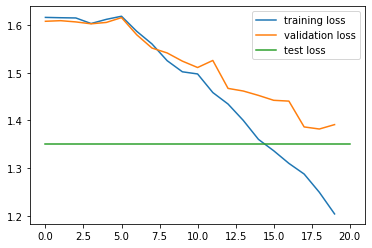

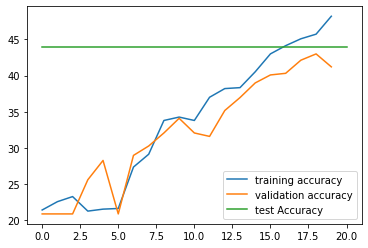

In [78]:
plot_results(results)

In [79]:
sample = "The merger did not work out"
predict_category(sample,args,pp,classifier)

'business'

In [81]:
sample = "India won by 7 wickets"
predict_category(sample,args,pp,classifier)

'business'

# Build Simple Word CNN

In [87]:
args.token_type = 'w'   # for Word tokenization, token_type should be set to 'w'
args.max_text_length = 256
args.tokenizer = Tokenizer(args).tokenizer
args.word_vectors = 'glove.6B.100d'   # when usinig word tokenization, we can use pre trained word vectors like Glove, FastText
pp = PreProcessor(args)

.vector_cache/glove.6B.zip: 862MB [06:30, 2.21MB/s]                           
100%|█████████▉| 399367/400000 [00:25<00:00, 18086.97it/s]

In [0]:
classifier = SimpleCNN(embedding_size=args.embedding_size,
                        num_embeddings=pp.get_text_vocab_length(),
                        num_channels=args.num_channels,
                        hidden_dim=args.hidden_dim,
                        num_classes=pp.get_label_vocab_length(),
                        dropout_p=args.dropout_p,
                        pretrained_embeddings=pp.get_embeddings(),
                        padding_idx=0)
classifier = classifier.to(args.device)

In [89]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                  mode='min', factor=0.5,
                                                  patience=1)
print("------- # of Parameters ---->: ", sum(p.numel() for p in classifier.parameters() if p.requires_grad))


------- # of Parameters ---->:  2631205


In [90]:
results = build_model(args, pp, classifier, loss_func, optimizer, scheduler);
print(results)

--------------------- @epoch  0 ---------------------
  training loss/accuracy 1.56402 / 32.04
validation loss/accuracy 1.33788 / 48.29
--------------------- @epoch  1 ---------------------
  training loss/accuracy 1.01827 / 54.40
validation loss/accuracy 0.62569 / 75.99
--------------------- @epoch  2 ---------------------
  training loss/accuracy 0.48007 / 82.39
validation loss/accuracy 0.40964 / 84.43
--------------------- @epoch  3 ---------------------
  training loss/accuracy 0.32735 / 88.54
validation loss/accuracy 0.45580 / 82.88
--------------------- @epoch  4 ---------------------
  training loss/accuracy 0.21719 / 91.62
validation loss/accuracy 0.35881 / 85.77
--------------------- @epoch  5 ---------------------
  training loss/accuracy 0.15187 / 94.31
validation loss/accuracy 0.31052 / 88.88
--------------------- @epoch  6 ---------------------
  training loss/accuracy 0.09448 / 96.89
validation loss/accuracy 0.18364 / 93.57
--------------------- @epoch  7 ----------------

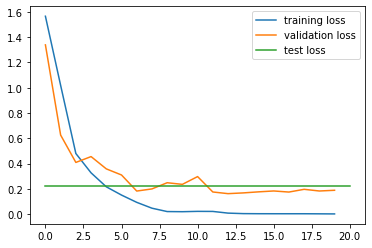

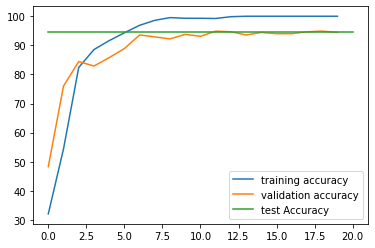

In [91]:
plot_results(results)

In [101]:
sample = "workers went on strike for increase of minimum wage"
predict_category(sample,args,pp,classifier)

'politics'

In [93]:
sample = "India won by 7 wickets"
predict_category(sample,args,pp,classifier)

'sport'

# Build CNN+Bidirectional LSTM

In [0]:
args.token_type = 'w'   # for Word tokenization, token_type should be set to 'w'
args.max_text_length = 256
args.tokenizer = Tokenizer(args).tokenizer
args.word_vectors = 'glove.6B.100d'   # when usinig word tokenization, we can use pre trained word vectors like Glove, FastText
pp = PreProcessor(args)

.vector_cache/glove.6B.zip: 862MB [06:30, 2.21MB/s]                           
100%|█████████▉| 399367/400000 [00:25<00:00, 18086.97it/s]

In [0]:
classifier = ConvRec_BiLSTM(text_length=args.max_text_length,
                            embedding_size=args.embedding_size,
                            num_embeddings=pp.get_text_vocab_length(),
                            num_channels=args.num_channels,
                            hidden_dim=args.hidden_dim,
                            num_classes=pp.get_label_vocab_length(),
                            dropout_p=args.dropout_p,
                            pretrained_embeddings=pp.get_embeddings(),
                            padding_idx=0)
classifier = classifier.to(args.device)

In [103]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                  mode='min', factor=0.5,
                                                  patience=1)
print("------- # of Parameters ---->: ", sum(p.numel() for p in classifier.parameters() if p.requires_grad))


------- # of Parameters ---->:  2712605


In [104]:
results = build_model(args, pp, classifier, loss_func, optimizer, scheduler);
print(results)

--------------------- @epoch  0 ---------------------
  training loss/accuracy 1.63606 / 22.90
validation loss/accuracy 1.60362 / 20.90
--------------------- @epoch  1 ---------------------
  training loss/accuracy 1.55749 / 30.73
validation loss/accuracy 1.48882 / 44.07
--------------------- @epoch  2 ---------------------
  training loss/accuracy 1.28379 / 44.88
validation loss/accuracy 1.20513 / 44.07
--------------------- @epoch  3 ---------------------
  training loss/accuracy 1.10704 / 48.55
validation loss/accuracy 1.21359 / 46.95
--------------------- @epoch  4 ---------------------
  training loss/accuracy 0.93503 / 60.54
validation loss/accuracy 0.88270 / 61.55
--------------------- @epoch  5 ---------------------
  training loss/accuracy 0.72990 / 71.02
validation loss/accuracy 0.74431 / 74.48
--------------------- @epoch  6 ---------------------
  training loss/accuracy 0.41579 / 88.21
validation loss/accuracy 0.48363 / 85.10
--------------------- @epoch  7 ----------------

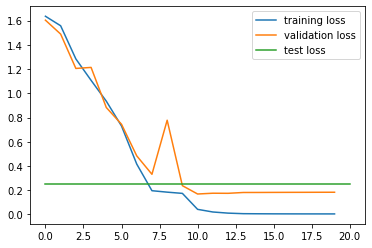

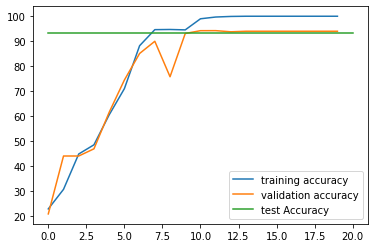

In [105]:
plot_results(results)

In [106]:
sample = "workers went on strike for increase of minimum wage"
predict_category(sample,args,pp,classifier)

'sport'

In [107]:
sample = "India won by 7 wickets"
predict_category(sample,args,pp,classifier)

'sport'

# *****************   End of NoteBook *****************